In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([3., 0.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p_data = 0.7 # prob of the first peak in data space
N = 10000 # amount of data

batch_size = 100
num_epoches = 250
z_dim = 2

In [4]:
c = torch.distributions.Bernoulli(p_data). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [5]:
X = c * a + (1 - c) * b
Y = torch.cat((X, c), 1)

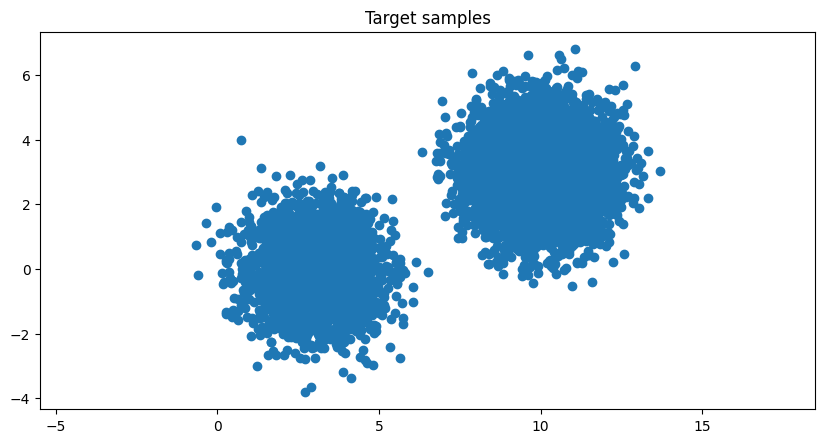

In [6]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu());

In [7]:
class VAE_stand_prior(nn.Module):
  def __init__(self):
    super(VAE_stand_prior, self).__init__()

    self.fc0 = nn.Linear(2, 5) # for encoder
    self.fc1 = nn.Linear(5, 10)
    self.fc2 = nn.Linear(10, z_dim) 
    self.fc3 = nn.Linear(10, z_dim)

    self.fc4 = nn.Linear(z_dim, 10) # for decoder
    self.fc5 = nn.Linear(10, 5)
    self.fc6 = nn.Linear(5, 2)

  def encode(self, x):
    h = torch.relu(self.fc0(x))
    g = torch.relu(self.fc1(h))
    return self.fc2(g), self.fc3(g) # mu and logvar -- parameters of q_{phi}
    
  def reparametrize(self, mu, logvar):
    std = torch.exp(logvar * 0.5)
    eps = torch.randn_like(std)
    return mu + eps * std
  
  def decode(self, z):
    h = torch.relu(self.fc4(z))
    g = torch.relu(self.fc5(h))
    return self.fc6(g) # mu_0 -- parameter of p_{theta}

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparametrize(mu, logvar)
    return self.decode(z), mu, logvar

In [8]:
model = VAE_stand_prior().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

In [9]:
def loss_function(x, mu_0, mu, logvar):
    KL = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()) # KL-divergence
    distr = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
    ELH = distr.log_prob(x) # 1-MC approximation of expected log likelihood
    return KL.mean() - ELH.mean()

In [10]:
dataloader = DataLoader(X, batch_size=batch_size, shuffle=True, )

In [11]:
for epoch in tqdm(range(num_epoches)):
    for batch in dataloader:
        mu_0, mu, logvar = model(batch)
        loss = loss_function(batch, mu_0, mu, logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 50 == 0:
        print("loss =", loss.cpu().detach().numpy())

  0%|          | 1/250 [00:00<01:04,  3.88it/s]

loss = 28.039415


 20%|██        | 51/250 [00:12<00:46,  4.27it/s]

loss = 3.221809


 40%|████      | 101/250 [00:23<00:35,  4.25it/s]

loss = 3.0722156


 60%|██████    | 151/250 [00:35<00:23,  4.29it/s]

loss = 3.171062


 80%|████████  | 201/250 [00:47<00:11,  4.19it/s]

loss = 3.0290773


100%|██████████| 250/250 [00:58<00:00,  4.25it/s]


##Generation

In [12]:
prior = torch.distributions.normal.Normal(torch.tensor(0., device=device, dtype=torch.float32),
                                          torch.tensor(1., device=device, dtype=torch.float32),)

In [13]:
pr_samples = prior.sample((1000, z_dim))

In [14]:
mu_0 = model.decode(pr_samples).detach().cpu()

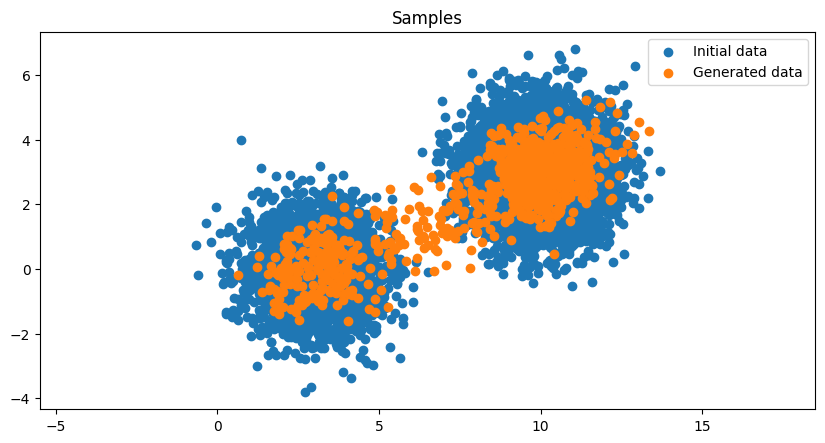

In [15]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X.cpu()[:, 0], X.cpu()[:, 1], label='Initial data')
plt.scatter(mu_0[:, 0], mu_0[:, 1], label='Generated data')
plt.axis('equal')
plt.legend();

##Prior visualization

No handles with labels found to put in legend.


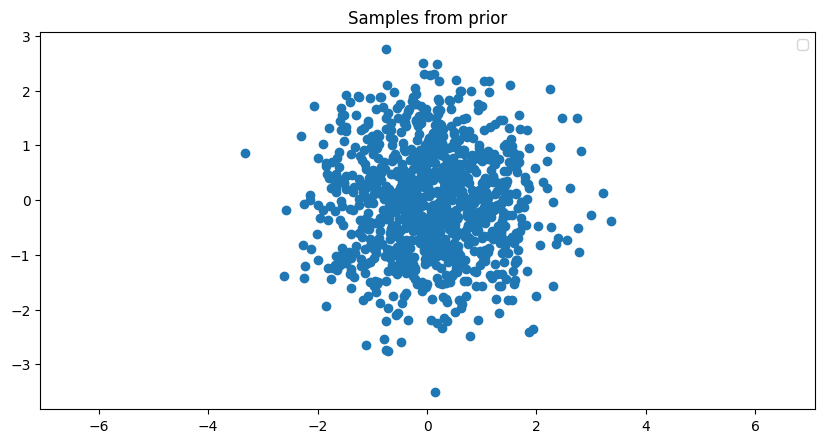

In [16]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples from prior')
plt.scatter(pr_samples[:, 0].cpu(), pr_samples[:, 1].cpu())
plt.axis('equal')
plt.legend();

##Reconstruction

In [17]:
X_rec = model(X) #reconstructed data

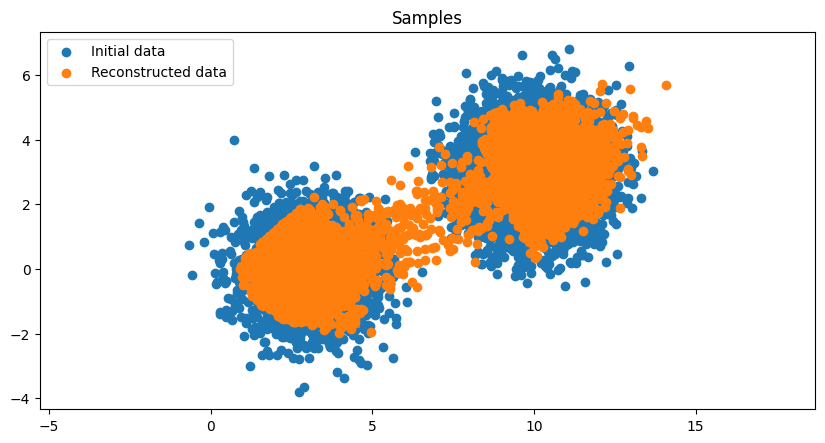

In [18]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(X_rec[0][:, 0].detach().cpu(), X_rec[0][:, 1].detach().cpu(), label='Reconstructed data')
plt.axis('equal')
plt.legend();

## Latent space illustration

In [19]:
mu_1, logvar_1 = model.encode(Y[Y[:, 2] == 0, 0:2])
mu_2, logvar_2 = model.encode(Y[Y[:, 2] == 1, 0:2])

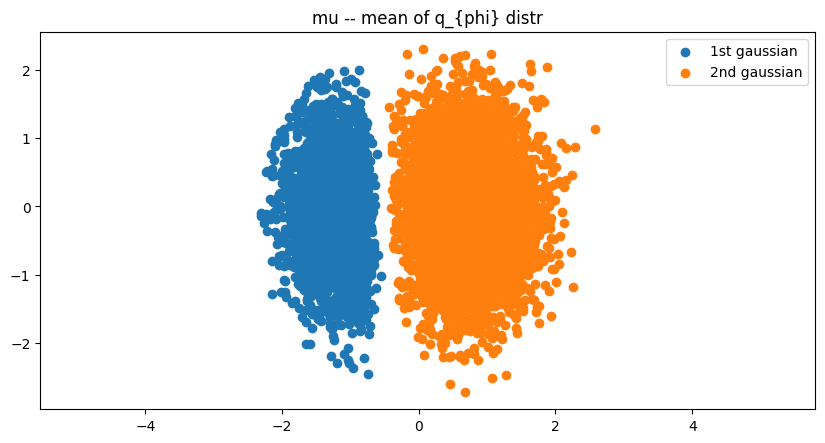

In [20]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('mu -- mean of q_{phi} distr')
plt.scatter(mu_1[:, 0].detach().cpu(), mu_1[:, 1].detach().cpu(), label='1st gaussian')
plt.scatter(mu_2[:, 0].detach().cpu(), mu_2[:, 1].detach().cpu(), label='2nd gaussian')
plt.axis('equal')
plt.legend();

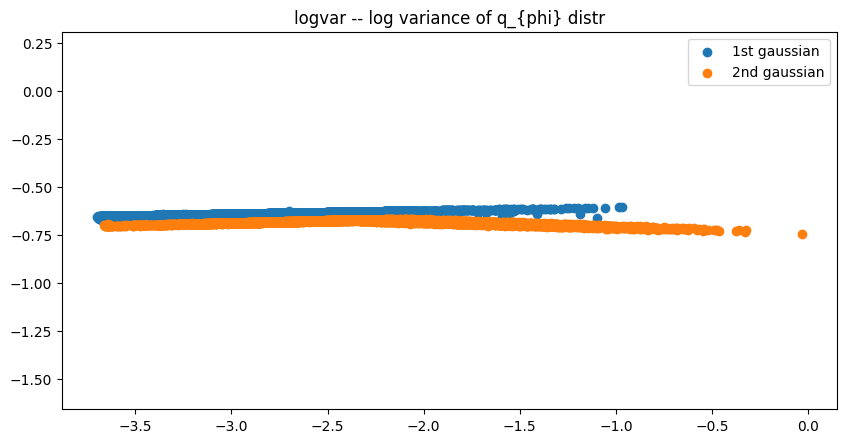

In [21]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('logvar -- log variance of q_{phi} distr')
plt.scatter(logvar_1[:, 0].detach().cpu(), logvar_1[:, 1].detach().cpu(), label='1st gaussian')
plt.scatter(logvar_2[:, 0].detach().cpu(), logvar_2[:, 1].detach().cpu(), label='2nd gaussian')
plt.axis('equal')
plt.legend();

## Estimation of $\log{p_{\theta}(X)}$

$\log{p_{\theta}(X)} = \sum{\log{p_{\theta}(x_i)}}$

Fixed $x\in X$:

$\log{p_{\theta}(x)} = \log{\int_{z}{p_{\theta}(x,z)dz}} = \log{\int_{z}{q_{\varphi}(z|x)\frac{p_{\theta}(x,z)}{q_{\varphi}(z|x)}dz}}\approx \log{\frac{1}{N_{s}}\sum_{i=1}^{N_{IS}}{\frac{p_{\theta}(x,z_{i})}{q_{\varphi}(z_{i}|x)}}} = -\log{N_{IS}} + \log sum_i \exp(\log{p_{\theta}(x, z_i)} - \log{q_{\varphi}(z_i|x)})$

In [22]:
N_IS = 10000
N_test = 5000

In [23]:
torch.manual_seed(0)
np.random.seed(0)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                        scale=torch.tensor(1., device=device, dtype=torch.float32))

In [24]:
c_test = torch.distributions.Bernoulli(p_data). sample((N_test, )).to(device).view(-1, 1)
a_test = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N_test, ))
b_test = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N_test, ))

In [25]:
X_test = c_test * a_test + (1 - c_test) * b_test

In [26]:
test_batch_size = 10
test_dataloader = DataLoader(X_test, batch_size=test_batch_size, shuffle=False, )

In [27]:
batch_mean = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.repeat(N_IS, 1)
        mu_q, logvar_q = model.encode(batch)
        
        eps = std_normal.sample(mu_q.shape)
        z = mu_q + eps * torch.exp(logvar_q * 0.5)
        m_0 = model.decode(z) # means of p_theta
        
        log_p_theta = torch.distributions.MultivariateNormal(loc=m_0, covariance_matrix=covar).log_prob(m_0)
        log_q = std_normal.log_prob(eps).sum(1)
        log_prior = std_normal.log_prob(z).sum(1)
        
        ll_raw = (log_p_theta + log_prior - log_q).view(*[N_IS, -1])
        
        ll_lse = torch.logsumexp(ll_raw, dim=0)
        ll = -np.log(N_IS) + torch.mean(ll_lse)
        batch_mean.append(torch.mean(ll).cpu().detach().numpy())

100%|██████████| 500/500 [00:18<00:00, 27.42it/s]


In [28]:
print("mean =", np.mean(batch_mean)) # mean of log p_{theta}(x)
print("std =", np.std(batch_mean))

mean = -0.7628778
std = 0.14471473
